<a href="https://colab.research.google.com/github/JohnnyPassos/recomendacao_similaridade/blob/main/recomendacao_similaridade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 96% 541M/565M [00:03<00:00, 217MB/s]
100% 565M/565M [00:03<00:00, 192MB/s]


In [5]:
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import os
import cv2
from tqdm import tqdm
import pickle

# Verificar se GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


In [7]:
# Explorar a estrutura do dataset
dataset_path = '/content/myntradataset'  # ajuste o caminho

# Listar estrutura de diretórios
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # mostra apenas os primeiros 5 arquivos
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... e mais {len(files) - 5} arquivos')

myntradataset/
  styles.csv
  images/
    32159.jpg
    45809.jpg
    22466.jpg
    8251.jpg
    16322.jpg
    ... e mais 44436 arquivos


In [8]:
class ImageFeatureExtractor:
    def __init__(self, model_name='resnet50', device='cpu'):
        self.device = device
        self.model_name = model_name

        # Carregar modelo pré-treinado
        if model_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
            # Remover a última camada de classificação
            self.model = nn.Sequential(*list(self.model.children())[:-1])
            self.feature_dim = 2048
        elif model_name == 'efficientnet_b0':
            self.model = models.efficientnet_b0(pretrained=True)
            self.model.classifier = nn.Identity()
            self.feature_dim = 1280

        self.model.to(device)
        self.model.eval()

        # Transformações para pré-processamento
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def extract_features(self, image_path):
        """Extrai features de uma única imagem"""
        try:
            # Carregar e preprocessar imagem
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)

            # Extrair features
            with torch.no_grad():
                features = self.model(image_tensor)
                features = features.view(features.size(0), -1)  # flatten

            return features.cpu().numpy()
        except Exception as e:
            print(f"Erro ao processar {image_path}: {e}")
            return None

    def extract_features_batch(self, image_paths, batch_size=32):
        """Extrai features em lotes para eficiência"""
        all_features = []
        valid_paths = []

        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            batch_valid_paths = []

            for path in batch_paths:
                try:
                    image = Image.open(path).convert('RGB')
                    image_tensor = self.transform(image)
                    batch_images.append(image_tensor)
                    batch_valid_paths.append(path)
                except:
                    continue

            if batch_images:
                batch_tensor = torch.stack(batch_images).to(self.device)

                with torch.no_grad():
                    features = self.model(batch_tensor)
                    features = features.view(features.size(0), -1)

                all_features.append(features.cpu().numpy())
                valid_paths.extend(batch_valid_paths)

        return np.vstack(all_features), valid_paths

In [9]:
class ImageSimilarityRecommender:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        self.image_features = None
        self.image_paths = None
        self.feature_index = None

    def build_index(self, image_directory):
        """Constrói o índice de features para todas as imagens"""
        print("Coletando caminhos das imagens...")
        image_paths = []

        # Buscar todas as imagens no diretório
        for root, dirs, files in os.walk(image_directory):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    image_paths.append(os.path.join(root, file))

        print(f"Encontradas {len(image_paths)} imagens")

        # Extrair features
        print("Extraindo features das imagens...")
        features, valid_paths = self.feature_extractor.extract_features_batch(image_paths)

        self.image_features = features
        self.image_paths = valid_paths

        print(f"Features extraídas para {len(valid_paths)} imagens")
        print(f"Dimensão das features: {features.shape}")

        return self

    def find_similar_images(self, query_image_path, top_k=5, metric='cosine'):
        """Encontra imagens similares à imagem de consulta"""
        if self.image_features is None:
            raise ValueError("Índice não foi construído. Execute build_index() primeiro.")

        # Extrair features da imagem de consulta
        query_features = self.feature_extractor.extract_features(query_image_path)

        if query_features is None:
            return []

        # Calcular similaridades
        if metric == 'cosine':
            similarities = cosine_similarity(query_features, self.image_features)[0]
        elif metric == 'euclidean':
            similarities = -np.linalg.norm(self.image_features - query_features, axis=1)

        # Obter top-k mais similares
        top_indices = np.argsort(similarities)[::-1][:top_k]

        results = []
        for idx in top_indices:
            results.append({
                'path': self.image_paths[idx],
                'similarity': similarities[idx],
                'index': idx
            })

        return results

    def visualize_results(self, query_image_path, results, figsize=(15, 10)):
        """Visualiza a imagem de consulta e os resultados similares"""
        fig, axes = plt.subplots(2, max(3, len(results)//2 + 1), figsize=figsize)
        axes = axes.flatten()

        # Mostrar imagem de consulta
        query_img = Image.open(query_image_path)
        axes[0].imshow(query_img)
        axes[0].set_title('Imagem de Consulta', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Mostrar resultados similares
        for i, result in enumerate(results, 1):
            if i < len(axes):
                img = Image.open(result['path'])
                axes[i].imshow(img)
                axes[i].set_title(f'Similaridade: {result["similarity"]:.3f}', fontsize=10)
                axes[i].axis('off')

        # Ocultar eixos não utilizados
        for i in range(len(results) + 1, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def save_index(self, filepath):
        """Salva o índice para reutilização"""
        data = {
            'features': self.image_features,
            'paths': self.image_paths,
            'model_name': self.feature_extractor.model_name
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"Índice salvo em: {filepath}")

    def load_index(self, filepath):
        """Carrega um índice salvo"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)

        self.image_features = data['features']
        self.image_paths = data['paths']
        print(f"Índice carregado de: {filepath}")
        return self

In [10]:
# Executar o sistema completo
def main():
    # Configurar caminhos
    dataset_path = '/content/myntradataset'

    # Inicializar o extrator de features
    print("Inicializando extrator de features...")
    feature_extractor = ImageFeatureExtractor(model_name='resnet50', device=device)

    # Criar sistema de recomendação
    print("Criando sistema de recomendação...")
    recommender = ImageSimilarityRecommender(feature_extractor)

    # Construir índice
    print("Construindo índice de features...")
    recommender.build_index(dataset_path)

    # Salvar índice para reutilização
    recommender.save_index('/content/fashion_similarity_index.pkl')

    return recommender

# Executar
recommender = main()

Inicializando extrator de features...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Criando sistema de recomendação...
Construindo índice de features...
Coletando caminhos das imagens...
Encontradas 44441 imagens
Extraindo features das imagens...


100%|██████████| 1389/1389 [03:28<00:00,  6.66it/s]


Features extraídas para 44441 imagens
Dimensão das features: (44441, 2048)
Índice salvo em: /content/fashion_similarity_index.pkl


In [11]:
class ImageSimilarityRecommender:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        self.image_features = None
        self.image_paths = None
        self.feature_index = None

    def build_index(self, image_directory):
        """Constrói o índice de features para todas as imagens"""
        print("Coletando caminhos das imagens...")
        image_paths = []

        # Buscar todas as imagens no diretório
        for root, dirs, files in os.walk(image_directory):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    image_paths.append(os.path.join(root, file))

        print(f"Encontradas {len(image_paths)} imagens")

        # Extrair features
        print("Extraindo features das imagens...")
        features, valid_paths = self.feature_extractor.extract_features_batch(image_paths)

        self.image_features = features
        self.image_paths = valid_paths

        print(f"Features extraídas para {len(valid_paths)} imagens")
        print(f"Dimensão das features: {features.shape}")

        return self

    def find_similar_images(self, query_image_path, top_k=5, metric='cosine'):
        """Encontra imagens similares à imagem de consulta"""
        if self.image_features is None:
            raise ValueError("Índice não foi construído. Execute build_index() primeiro.")

        # Extrair features da imagem de consulta
        query_features = self.feature_extractor.extract_features(query_image_path)

        if query_features is None:
            return []

        # Calcular similaridades
        if metric == 'cosine':
            similarities = cosine_similarity(query_features, self.image_features)[0]
        elif metric == 'euclidean':
            similarities = -np.linalg.norm(self.image_features - query_features, axis=1)

        # Obter top-k mais similares
        top_indices = np.argsort(similarities)[::-1][:top_k]

        results = []
        for idx in top_indices:
            results.append({
                'path': self.image_paths[idx],
                'similarity': similarities[idx],
                'index': idx
            })

        return results

    def visualize_results(self, query_image_path, results, figsize=(15, 10)):
        """Visualiza a imagem de consulta e os resultados similares"""
        fig, axes = plt.subplots(2, max(3, len(results)//2 + 1), figsize=figsize)
        axes = axes.flatten()

        # Mostrar imagem de consulta
        query_img = Image.open(query_image_path)
        axes[0].imshow(query_img)
        axes[0].set_title('Imagem de Consulta', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Mostrar resultados similares
        for i, result in enumerate(results, 1):
            if i < len(axes):
                img = Image.open(result['path'])
                axes[i].imshow(img)
                axes[i].set_title(f'Similaridade: {result["similarity"]:.3f}', fontsize=10)
                axes[i].axis('off')

        # Ocultar eixos não utilizados
        for i in range(len(results) + 1, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def save_index(self, filepath):
        """Salva o índice para reutilização"""
        data = {
            'features': self.image_features,
            'paths': self.image_paths,
            'model_name': self.feature_extractor.model_name
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"Índice salvo em: {filepath}")

    def load_index(self, filepath):
        """Carrega um índice salvo"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)

        self.image_features = data['features']
        self.image_paths = data['paths']
        print(f"Índice carregado de: {filepath}")
        return self

In [12]:
# Executar o sistema completo
def main():
    # Configurar caminhos
    dataset_path = '/content/myntradataset'  # ajuste conforme necessário

    # Inicializar o extrator de features
    print("Inicializando extrator de features...")
    feature_extractor = ImageFeatureExtractor(model_name='resnet50', device=device)

    # Criar sistema de recomendação
    print("Criando sistema de recomendação...")
    recommender = ImageSimilarityRecommender(feature_extractor)

    # Construir índice
    print("Construindo índice de features...")
    recommender.build_index(dataset_path)

    # Salvar índice para reutilização
    recommender.save_index('/content/fashion_similarity_index.pkl')

    return recommender

# Executar
recommender = main()

Inicializando extrator de features...
Criando sistema de recomendação...
Construindo índice de features...
Coletando caminhos das imagens...
Encontradas 44441 imagens
Extraindo features das imagens...


100%|██████████| 1389/1389 [03:25<00:00,  6.75it/s]


Features extraídas para 44441 imagens
Dimensão das features: (44441, 2048)
Índice salvo em: /content/fashion_similarity_index.pkl


Executando teste com imagem da internet...
=== TESTE COM IMAGEM DA INTERNET ===

Opções de teste:
1. https://acdn-us.mitiendanube.com/stores/002/260/329/products/camiseta-justiceiro-punisher-fractalmw-fractal-music-wear-fractalmusicwear-piracicaba1-55b384ee73e20acb3f16617973392908-1024-1024.jpg
2. https://dzg5mdpaq0k37.cloudfront.net/Custom/Content/Products/96/46/9646_women-straight-jeans-82133_m4_638605155383362873.webp
3. https://waytenis.vteximg.com.br/arquivos/ids/185046-1000-1000/dc3728-tenis-nike-masculino-revolution-6-preto-vandacalcados2.jpg?v=638072455324330000
4. https://adaptive-images.uooucdn.com.br/ik-seo/tr:w-1100,h-1594,c-at_max,pr-true,q-80/a22263-ogxythlhwt0/pv/00/41/9d/1700b93ba7daea98935480a1dc/vestido-feminino-midi-athenas-azul-claro-large-3.jpg
5. Inserir URL personalizada

Escolha uma opção (1-5): 1

Baixando imagem de: https://acdn-us.mitiendanube.com/stores/002/260/329/products/camiseta-justiceiro-punisher-fractalmw-fractal-music-wear-fractalmusicwear-piracicaba

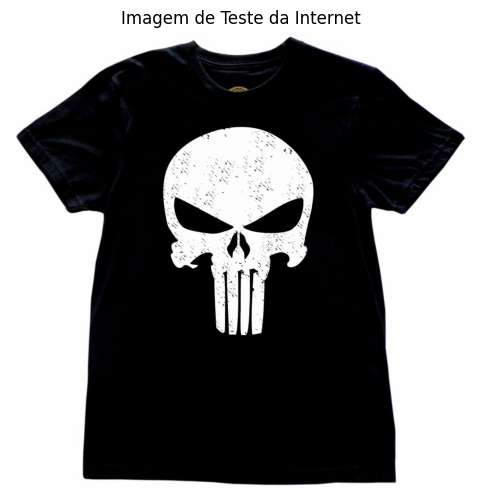


Buscando imagens similares no dataset...

Encontradas 6 imagens similares:


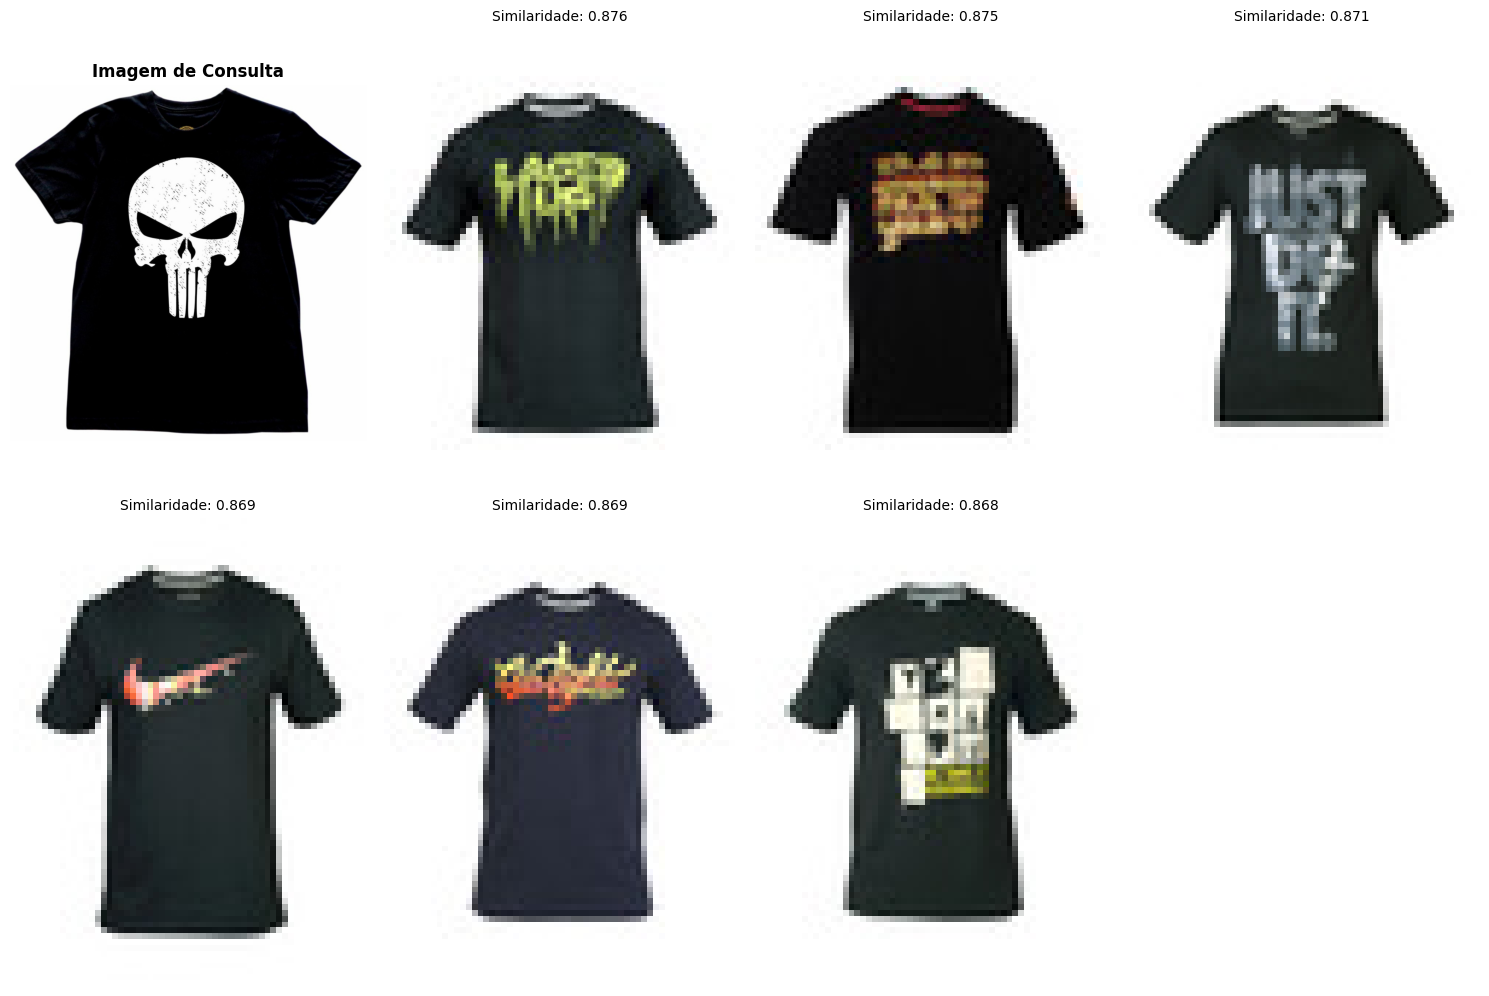


=== RESULTADOS DETALHADOS ===
 1. Similaridade:  87.60% - 11269.jpg
 2. Similaridade:  87.50% - 10032.jpg
 3. Similaridade:  87.13% - 38644.jpg
 4. Similaridade:  86.89% - 7585.jpg
 5. Similaridade:  86.88% - 15636.jpg
 6. Similaridade:  86.82% - 9558.jpg

=== ANÁLISE ===
Maior similaridade: 0.8760
Menor similaridade: 0.8682
Similaridade média: 0.8713


In [13]:
import requests
from io import BytesIO
import urllib.parse

def download_image_from_url(url, save_path):
    """Baixa uma imagem da internet e salva localmente"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Salvar imagem
        with open(save_path, 'wb') as f:
            f.write(response.content)

        print(f"Imagem baixada com sucesso: {save_path}")
        return True
    except Exception as e:
        print(f"Erro ao baixar imagem: {e}")
        return False

def test_with_internet_image():
    """Testa o sistema de recomendação com uma imagem da internet"""

    # URLs de exemplo de roupas/moda (você pode substituir por qualquer URL)
    test_urls = [
        "https://acdn-us.mitiendanube.com/stores/002/260/329/products/camiseta-justiceiro-punisher-fractalmw-fractal-music-wear-fractalmusicwear-piracicaba1-55b384ee73e20acb3f16617973392908-1024-1024.jpg",  # camiseta
        "https://dzg5mdpaq0k37.cloudfront.net/Custom/Content/Products/96/46/9646_women-straight-jeans-82133_m4_638605155383362873.webp",  # jeans
        "https://waytenis.vteximg.com.br/arquivos/ids/185046-1000-1000/dc3728-tenis-nike-masculino-revolution-6-preto-vandacalcados2.jpg?v=638072455324330000",  # sneakers
        "https://adaptive-images.uooucdn.com.br/ik-seo/tr:w-1100,h-1594,c-at_max,pr-true,q-80/a22263-ogxythlhwt0/pv/00/41/9d/1700b93ba7daea98935480a1dc/vestido-feminino-midi-athenas-azul-claro-large-3.jpg", # vestido
    ]

    # Criar diretório para imagens de teste se não existir
    test_dir = "/content/test_images"
    os.makedirs(test_dir, exist_ok=True)

    print("=== TESTE COM IMAGEM DA INTERNET ===\n")

    # Opção 1: Usar uma URL pré-definida
    print("Opções de teste:")
    for i, url in enumerate(test_urls, 1):
        print(f"{i}. {url}")

    print("5. Inserir URL personalizada")

    try:
        choice = input("\nEscolha uma opção (1-5): ").strip()

        if choice in ['1', '2', '3', '4']:
            selected_url = test_urls[int(choice) - 1]
        elif choice == '5':
            selected_url = input("Digite a URL da imagem: ").strip()
        else:
            print("Opção inválida. Usando URL padrão...")
            selected_url = test_urls[0]

    except:
        # Para execução automática no Colab, usar URL padrão
        selected_url = test_urls[0]
        print(f"Usando URL padrão: {selected_url}")

    # Nome do arquivo baseado na URL
    filename = f"test_image_{hash(selected_url) % 10000}.jpg"
    test_image_path = os.path.join(test_dir, filename)

    # Baixar imagem
    print(f"\nBaixando imagem de: {selected_url}")
    if download_image_from_url(selected_url, test_image_path):

        # Verificar se a imagem foi baixada corretamente
        try:
            test_img = Image.open(test_image_path)
            print(f"Imagem carregada: {test_img.size}")

            # Mostrar a imagem de teste
            plt.figure(figsize=(6, 6))
            plt.imshow(test_img)
            plt.title("Imagem de Teste da Internet")
            plt.axis('off')
            plt.show()

            # Encontrar imagens similares
            print("\nBuscando imagens similares no dataset...")
            similar_images = recommender.find_similar_images(
                test_image_path,
                top_k=6,
                metric='cosine'
            )

            # Visualizar resultados
            print(f"\nEncontradas {len(similar_images)} imagens similares:")
            recommender.visualize_results(test_image_path, similar_images)

            # Mostrar métricas detalhadas
            print("\n=== RESULTADOS DETALHADOS ===")
            for i, result in enumerate(similar_images):
                similarity_percent = result['similarity'] * 100
                filename = os.path.basename(result['path'])
                print(f"{i+1:2d}. Similaridade: {similarity_percent:6.2f}% - {filename}")

            # Análise adicional
            print(f"\n=== ANÁLISE ===")
            print(f"Maior similaridade: {similar_images[0]['similarity']:.4f}")
            print(f"Menor similaridade: {similar_images[-1]['similarity']:.4f}")
            print(f"Similaridade média: {np.mean([r['similarity'] for r in similar_images]):.4f}")

            return test_image_path, similar_images

        except Exception as e:
            print(f"Erro ao processar imagem baixada: {e}")
            return None, None
    else:
        print("Falha ao baixar imagem. Testando com imagem do dataset...")
        return test_with_dataset_image()

def test_with_dataset_image():
    """Fallback: testa com uma imagem do próprio dataset"""
    print("\n=== TESTE COM IMAGEM DO DATASET ===")

    # Pegar uma imagem aleatória do dataset
    import random
    test_image = random.choice(recommender.image_paths)
    print(f"Usando imagem do dataset: {os.path.basename(test_image)}")

    # Mostrar a imagem de teste
    plt.figure(figsize=(6, 6))
    test_img = Image.open(test_image)
    plt.imshow(test_img)
    plt.title("Imagem de Teste (Dataset)")
    plt.axis('off')
    plt.show()

    # Encontrar imagens similares (excluindo a própria imagem)
    similar_images = recommender.find_similar_images(
        test_image,
        top_k=7,
        metric='cosine'
    )[1:]  # Remover a primeira (que é a própria imagem)

    # Visualizar resultados
    recommender.visualize_results(test_image, similar_images)

    return test_image, similar_images

def interactive_test():
    """Função para teste interativo contínuo"""
    print("=== MODO TESTE INTERATIVO ===")
    print("Digite URLs de imagens para testar ou 'quit' para sair")

    while True:
        url = input("\nURL da imagem (ou 'quit'): ").strip()

        if url.lower() in ['quit', 'exit', 'q']:
            break

        if url:
            # Criar nome único para a imagem
            filename = f"interactive_test_{hash(url) % 10000}.jpg"
            test_path = f"/content/test_images/{filename}"

            if download_image_from_url(url, test_path):
                try:
                    similar_images = recommender.find_similar_images(test_path, top_k=5)
                    recommender.visualize_results(test_path, similar_images)

                    print("Top 3 similaridades:")
                    for i, result in enumerate(similar_images[:3]):
                        print(f"  {i+1}. {result['similarity']:.4f} - {os.path.basename(result['path'])}")

                except Exception as e:
                    print(f"Erro ao processar: {e}")

# Executar teste principal
print("Executando teste com imagem da internet...")
test_image_path, results = test_with_internet_image()

=== TESTE EM LOTE COM IMAGENS DA INTERNET ===


--- Teste 1: Camiseta básica ---
Imagem baixada com sucesso: /content/test_images/batch_test_1.jpg
Melhor match: 0.8760


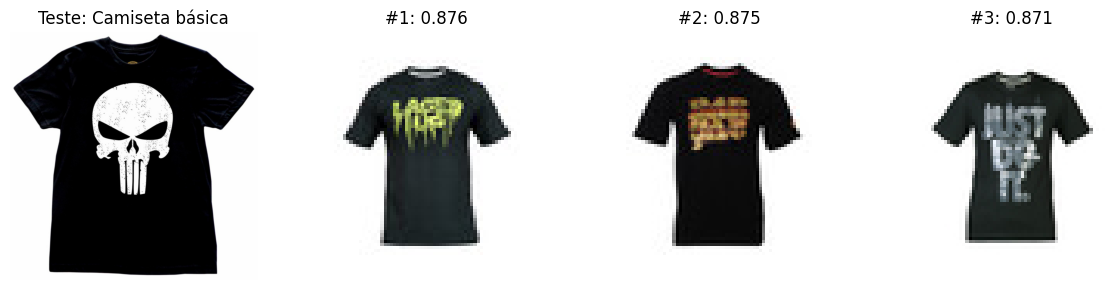


--- Teste 2: Calça jeans ---
Imagem baixada com sucesso: /content/test_images/batch_test_2.jpg
Melhor match: 0.8439


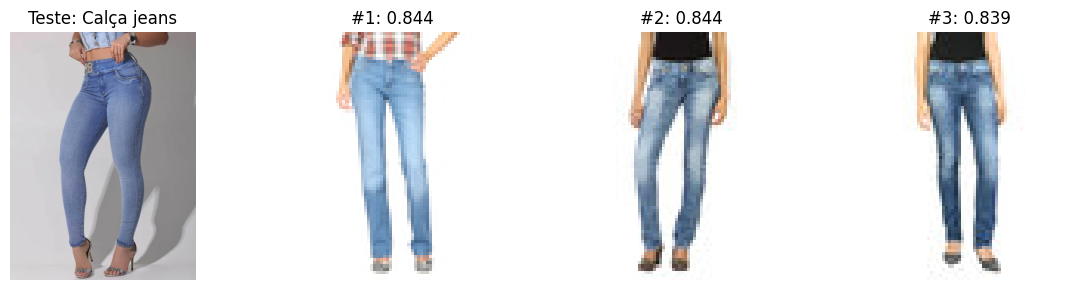


--- Teste 3: Tênis esportivo ---
Imagem baixada com sucesso: /content/test_images/batch_test_3.jpg
Melhor match: 0.8498


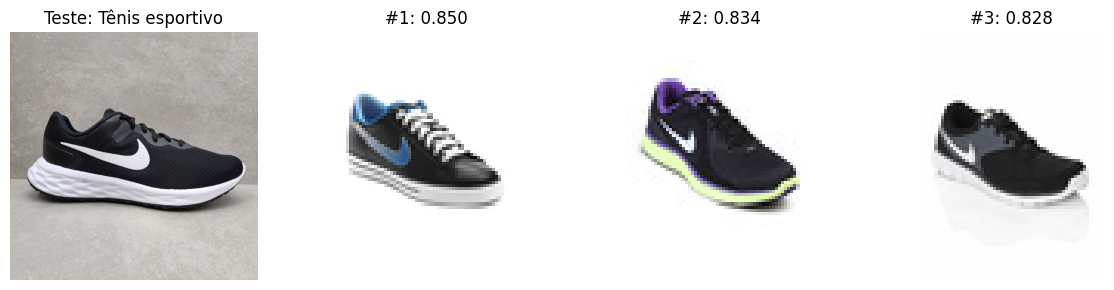


--- Teste 4: Vestido Elegante ---
Imagem baixada com sucesso: /content/test_images/batch_test_4.jpg
Melhor match: 0.7586


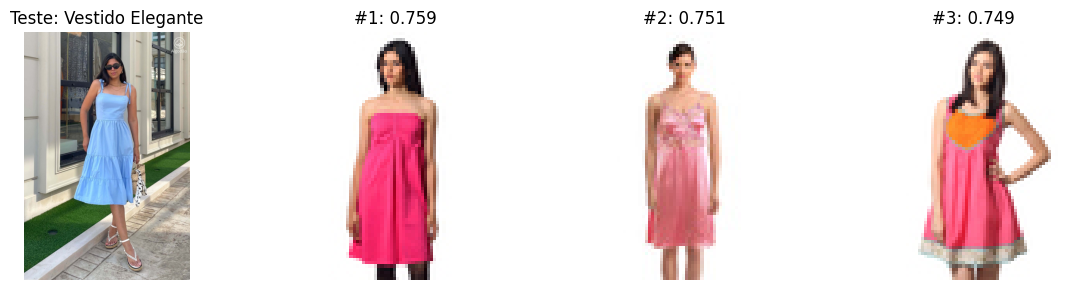


=== RESUMO DOS TESTES ===
Camiseta básica | Similaridade: 0.8760 | Match: 11269.jpg
Calça jeans     | Similaridade: 0.8439 | Match: 11303.jpg
Tênis esportivo | Similaridade: 0.8498 | Match: 42043.jpg
Vestido Elegante | Similaridade: 0.7586 | Match: 35990.jpg


In [16]:
def batch_test_internet_images():
    """Testa com múltiplas imagens da internet de uma vez"""

    # URLs de diferentes tipos de produtos de moda
    test_batch = [
        {
            'url': 'https://acdn-us.mitiendanube.com/stores/002/260/329/products/camiseta-justiceiro-punisher-fractalmw-fractal-music-wear-fractalmusicwear-piracicaba1-55b384ee73e20acb3f16617973392908-1024-1024.jpg',
            'description': 'Camiseta básica'
        },
        {
            'url': 'https://dzg5mdpaq0k37.cloudfront.net/Custom/Content/Products/96/46/9646_women-straight-jeans-82133_m4_638605155383362873.webp',
            'description': 'Calça jeans'
        },
        {
            'url': 'https://waytenis.vteximg.com.br/arquivos/ids/185046-1000-1000/dc3728-tenis-nike-masculino-revolution-6-preto-vandacalcados2.jpg?v=638072455324330000',
            'description': 'Tênis esportivo'
        },
        {
            'url': 'https://adaptive-images.uooucdn.com.br/ik-seo/tr:w-1100,h-1594,c-at_max,pr-true,q-80/a22263-ogxythlhwt0/pv/00/41/9d/1700b93ba7daea98935480a1dc/vestido-feminino-midi-athenas-azul-claro-large-3.jpg',
             'description': 'Vestido Elegante'
        }
    ]

    print("=== TESTE EM LOTE COM IMAGENS DA INTERNET ===\n")

    results_summary = []

    for i, item in enumerate(test_batch, 1):
        print(f"\n--- Teste {i}: {item['description']} ---")

        filename = f"batch_test_{i}.jpg"
        test_path = f"/content/test_images/{filename}"

        if download_image_from_url(item['url'], test_path):
            try:
                # Buscar similaridades
                similar_images = recommender.find_similar_images(test_path, top_k=3)

                # Mostrar apenas a melhor similaridade
                if similar_images:
                    best_match = similar_images[0]
                    print(f"Melhor match: {best_match['similarity']:.4f}")

                    results_summary.append({
                        'description': item['description'],
                        'best_similarity': best_match['similarity'],
                        'best_match_file': os.path.basename(best_match['path'])
                    })

                    # Visualização compacta
                    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

                    # Imagem teste
                    test_img = Image.open(test_path)
                    axes[0].imshow(test_img)
                    axes[0].set_title(f"Teste: {item['description']}")
                    axes[0].axis('off')

                    # Top 3 matches
                    for j, result in enumerate(similar_images[:3]):
                        match_img = Image.open(result['path'])
                        axes[j+1].imshow(match_img)
                        axes[j+1].set_title(f"#{j+1}: {result['similarity']:.3f}")
                        axes[j+1].axis('off')

                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Erro ao processar {item['description']}: {e}")

    # Resumo final
    print("\n=== RESUMO DOS TESTES ===")
    for result in results_summary:
        print(f"{result['description']:15} | Similaridade: {result['best_similarity']:.4f} | Match: {result['best_match_file']}")

# Executar teste em lote (opcional)
(batch_test_internet_images())